# Task 2 

## Problem Statement

_Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability._

**Requirements:**
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

**Bonus question:
How to make sure you produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$?**

---

Environment details and general configuration...

In [1]:
%autosave 15
import qiskit
qiskit.__qiskit_version__

Autosaving every 15 seconds


{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

In [2]:
# imports and general configuration
import random
import numpy as np

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import clear_output

from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

statevector_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2020-09-13 17:37:35,157: Credentials are already in use. The existing account in the session will be replaced.


## Creating a reference circuit

For starters, I decided to make a reference circuit that creates the state $\lvert\psi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}\lvert10\rangle$ (upto a global phase) using only RX, RY, and CX gates. The intention behind this was just to get a feel of the RX and RY gates and do some visualization...

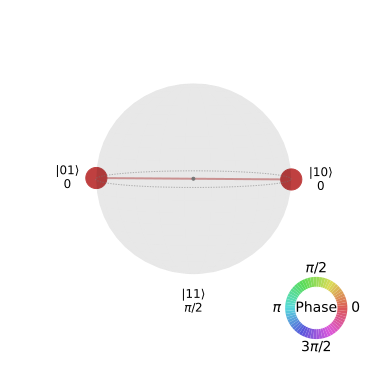

In [34]:
t2_ref_ckt = QuantumCircuit(2)

# X gate on qubit 1
t2_ref_ckt.rx(np.pi, 1)
# Hadamard on qubit 0
t2_ref_ckt.ry(np.pi/2, 0) 
t2_ref_ckt.rx(np.pi, 0)

# CNOT with qubit 0 as control and qubit 1 as target
t2_ref_ckt.cx(0,1)

# evolving the Statevector() using the QuantumCircuit() to reach the final state
# this way there's no need for a simulator 
ref_sv = Statevector.from_label('00').evolve(t2_ref_ckt)

# plot the state on the q-sphere for visualization
plot_q(ref_sv, figsize=(6.5,6.5), show_state_phases=True)

# Approaches

# 1. Fixed Circuit + Gradient Descent implemented by hand + Noisy Simulations (noise + sampling error from simulator)

This first approach is straightforward. The order of the gates is fixed and I'm attempting to learn the parameters of the RX and RY gates using Gradient Descent...  

In order to measure $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability, we must generate a state 
$$
\lvert\psi\rangle = \alpha\lvert01\rangle + \beta\lvert10\rangle
$$
satisfying
$$
\left\lVert\alpha^2\right\rVert = \left\lVert\beta^2\right\rVert = 0.5
$$

The easiest way to generate this state is to first create $\lvert\psi^\prime\rangle = \alpha\lvert01\rangle + \beta\lvert11\rangle = \big(\alpha\lvert0\rangle + \beta\lvert1\rangle \big) \otimes\lvert1\rangle$, and then apply a CX gate to this state controlled on the first qubit and targeting the second.

The state $\big(\alpha\lvert0\rangle + \beta\lvert1\rangle \big) \otimes\lvert1\rangle$ is (obviously) completely separable, which means I can treat each qubit individually and optimize one at a time.  
  
**In this case, the  first qubit must, at the end of the circuit, give you an equal probability of measuring $\lvert0\rangle$ (eigen value 1) and $\lvert1\rangle$ (eigen value -1).  
The second qubit must end up in the state $\lvert1\rangle$ (upto a global phase).**

Given the restriction that I can use only $RY(\theta)$ and $RX(\theta)$ gates, I decided to fix the structure of the circuit as shown below...

Circuit created with random initialization of parameters...


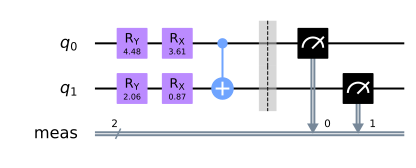

In [3]:
def create_complete_circuit(q1_thetas, q2_thetas):
    t2_ckt = QuantumCircuit(2)

    t2_ckt.ry(q1_thetas[0], 0)
    t2_ckt.rx(q1_thetas[1], 0)

    t2_ckt.ry(q2_thetas[0], 1)
    t2_ckt.rx(q2_thetas[1], 1)

    t2_ckt.cx(0, 1)

    t2_ckt.measure_all()
    
    return t2_ckt

#========================================================
# Initialize random circuit parameters
#========================================================

# q0_thetas is a list of 2 angles (between 0 and 2*pi) which parametrize the RY and RX gates on qubit 1 respectively
q1_thetas = 2 * np.pi * np.random.rand(2)
# same as q1_thetas but for qubit 2
q2_thetas = 2 * np.pi * np.random.rand(2)

t2_ckt = create_complete_circuit(q1_thetas, q2_thetas)

print("Circuit created with random initialization of parameters...")
t2_ckt.draw('mpl')

---

## 1.1. Calculation

Gradient Descent is a fairly simple algorithm to implement from scratch. Since we're working with individual qubits and optimizing over 2 gates only, it is easy to construct the unitary matrix representing the effect of the circuit on each qubit.  
  
  
Let $\theta_1$ be the rotation angle of the $RY$ Gate, and $\theta_2$ be the rotation angle of the $RX$ Gate.
  
The unitary matrices corresponding to the $RY$ and $RX$ gates are given by:
$$
\begin{aligned}
    RY(\theta_1) & = 
    \begin{bmatrix} 
        cos(\frac{\theta_1}{2}) & -sin(\frac{\theta_1}{2}) \\ 
        sin(\frac{\theta_1}{2}) & cos(\frac{\theta_1}{2})
    \end{bmatrix}\\
    RX(\theta_2) & = 
    \begin{bmatrix} 
        cos(\frac{\theta_2}{2}) & -isin(\frac{\theta_2}{2}) \\ 
        -isin(\frac{\theta_2}{2}) & cos(\frac{\theta_2}{2})
    \end{bmatrix}\\
\end{aligned}
$$  

### Arriving at the final state in terms of parameters $\theta_1$ and $\theta_2$:
  
We start in the state $\lvert0\rangle = \begin{bmatrix} 1\\0 \end{bmatrix}$, and then apply $RY(\theta_1)$ followed by $RX(\theta_2)$...

$$
\begin{bmatrix} 
    1 \\
    0 
\end{bmatrix}
\xrightarrow{RY(\theta_1)}
\begin{bmatrix} 
    cos(\frac{\theta_1}{2}) \\
    sin(\frac{\theta_1}{2})
\end{bmatrix}
\xrightarrow{RX(\theta_2)}
\begin{bmatrix} 
    cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) - isin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) \\
    -icos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) + sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})
\end{bmatrix}
$$

### Probabilities of measuring $\lvert0\rangle$ and $\lvert1\rangle$:
$$
\begin{aligned}
P_0 & = cos^2\big(\frac{\theta_1}{2}\big)cos^2\big(\frac{\theta_2}{2}\big) + sin^2\big(\frac{\theta_1}{2}\big)sin^2\big(\frac{\theta_2}{2}\big) \\
P_1 & = cos^2\big(\frac{\theta_1}{2}\big)sin^2\big(\frac{\theta_2}{2}\big) + sin^2\big(\frac{\theta_1}{2}\big)cos^2\big(\frac{\theta_2}{2}\big)
\end{aligned}
$$

### Cost Function:

The cost function must be one that penalizes a circuit which yields measurement probabilities that we don't want.

#### For qubit 1:
We want qubit 1 to end up in a state with equal probabilities ($\frac{1}{2}$ each) of measuring $\lvert0\rangle$ and $\lvert1\rangle$. So a reasonable cost function is:
$$
J_1 = \frac{1}{2}(P_0 - 0.5)^2 + \frac{1}{2}(P_1 - 0.5)^2
$$
but since $P_0 + P_1 = 1$, this reduces to:
$$
J_1 = (P_0 - 0.5)^2
$$

#### For qubit 2:
We want qubit 2 to end up in the state $\lvert1\rangle$, so we would like $P_0$ to be $0$ and $P_1$ to be $1$: 
$$
J_2 = \frac{1}{2}(P_0)^2 + \frac{1}{2}(P_1 - 1)^2
$$  
which reduces to
$$
J_2 = (P_0)^2
$$

where the factors of $\frac{1}{2}$ are taken for convenience with derivatives...  

  
### Partial Derivatives

At any step during the optimization, gradient descent changes the values of each parameter by an amount proportional to the partial derivative of the cost function with respect to that parameter at that point.  
  
The partial derivatives of the cost function are given by -  
**for qubit 1:**
$ \frac{\partial J_1}{\partial \theta_i} = 2 * (P_0 - 0.5) * \frac{\partial P_0}{\partial \theta_i} $
  
**for qubit 2:**
$ \frac{\partial J_2}{\partial \theta_i} = 2 * (P_0) * \frac{\partial P_0}{\partial \theta_i} $
  
### Calculations for $ \frac{\partial P_i}{\partial \theta_j} $:
    
$$
\begin{aligned}
    \frac{\partial P_0}{\partial \theta_1} & = -sin\theta_1cos^2\frac{\theta_2}{2} + sin\theta_1sin^2\frac{\theta_2}{2} \\
    & = -sin\theta_1\big(cos^2\frac{\theta_2}{2} - sin^2\frac{\theta_2}{2}\big) \\
    & = -sin\theta_1cos\theta_2 \\
    \\
    \frac{\partial P_0}{\partial \theta_2} & = -cos^2\frac{\theta_1}{2}sin\theta_2 + sin^2\frac{\theta_1}{2}sin\theta_2 \\
    & = -cos\theta_1sin\theta_2 \\
    \\
    \frac{\partial P_1}{\partial \theta_1} & = cos^2\frac{\theta_2}{2}sin\theta_1 - sin^2\frac{\theta_2}{2}sin\theta_1 \\
    & = sin\theta_1cos\theta_2 \\
    \\
    \frac{\partial P_1}{\partial \theta_2} & = -sin^2\frac{\theta_1}{2}sin\theta_2 + cos^2\frac{\theta_1}{2}sin\theta_2 \\
    & = cos\theta_1sin\theta_2 \\
\end{aligned}
$$
  
  
#### Substituting these values and re-arranging some terms:  
**for qubit 1:**  
$\frac{\partial J_1}{\partial \theta_1} = sin\theta_1cos\theta_2(P_1-P_0)$
  
and  

$\frac{\partial J_1}{\partial \theta_2} = sin\theta_2cos\theta_1(P_1-P_0)$  
  
**for qubit 2:**  
$\frac{\partial J_2}{\partial \theta_1} = sin\theta_1cos\theta_2(P_1 - P_0 - 1)$
  
and  

$\frac{\partial J_2}{\partial \theta_2} = sin\theta_2cos\theta_1(P_1 - P_0 - 1)$  

---

We can now write helper functions to create the circuit, compute the costs and gradients, and to retrieve $P_0$ and $P_1$ from Qiskit's `Result` object...

In [4]:
def create_single_qubit_circuit(thetas, measure=True):
    
    ckt = QuantumCircuit(1)
    ckt.ry(thetas[0], 0)
    ckt.rx(thetas[1], 0)
    if measure:
        ckt.measure_all()

    return ckt

def compute_cost_qubit1 (p0, p1):
    return (p0 - 0.5) ** 2

def compute_cost_qubit2 (p0, p1):
    return p0 ** 2

def compute_gradient_qubit1(learning_rate, thetas, p0, p1):
    
    grad_1 = np.sin(thetas[0]) * np.cos(thetas[1]) * (p1 - p0)
    grad_2 = np.sin(thetas[1]) * np.cos(thetas[0]) * (p1 - p0)
    
    return [learning_rate * grad_1, learning_rate * grad_2]

def compute_gradient_qubit2(learning_rate, thetas, p0, p1):
    
    grad_1 = np.sin(thetas[0]) * np.cos(thetas[1]) * (p1 - p0 - 1)
    grad_2 = np.sin(thetas[1]) * np.cos(thetas[0]) * (p1 - p0 - 1)
    
    return [learning_rate * grad_1, learning_rate * grad_2]

def get_probabilities (backend, result, shots):
    
    if backend == qasm_sim:
        counts = result.get_counts()
        
    elif backend == statevector_sim:
        counts = Statevector(result.get_statevector()).probabilities_dict()
        
    try:
        p0 = counts['0'] / shots
    except:
        p0 = 0
    
    try:
        p1 = counts['1'] / shots
    except:
        p1 = 0
        
    return (p0, p1)

We also need a function that will carry out gradient descent to optimize $\theta_1$ and $\theta_2$ on a given single qubit circuit...

In [5]:
# learning rate
alpha = 0.1
# number of steps
iterations = 1000
# values for number of measurement shots per iteration
shots = [1, 10, 100, 1000]
# for displaying a progress bar during optimization
progress_bar_length = 20

def get_progress_bar(iteration):
    progress = iteration / iterations
    current_bar_length = int(progress_bar_length * progress)

    text = "\rProgress: [{0}] {1:.1f}%"\
        .format("#" * current_bar_length + "-" * (progress_bar_length - current_bar_length), 100 * progress)
    
    return text

In [6]:
def optimize_angles(circuit_creator, measure, backend, shots, compute_gradient, compute_cost):
    
    costs = []
    if backend == qasm_sim:
        noise = noise_model
    else:
        noise = None
    
    # Generate a circuit with random parameters
    thetas = 2 * np.pi * np.random.rand(2)
    circuit = circuit_creator(thetas, measure)
    
    print("\n=============================================")
    print("Running gradient descent with shots = {} ...".format(shots))
    
    for iteration in range(1, iterations + 1):

        result = execute(circuit, backend=backend, shots=shots, noise_model=noise).result()

        (p0, p1) = get_probabilities(backend, result, shots)
        cost = compute_cost(p0, p1)
        costs.append(cost)

        # Compute Gradient
        delta = compute_gradient(alpha, thetas, p0, p1)
        
        # Update angles
        thetas = thetas - delta
                  
        print(get_progress_bar(iteration), end='')
        
        circuit = circuit_creator(thetas, measure)
    
    print("\n=============================================\n")
    return circuit, thetas, costs

---

## 1.2. Qubit 1

Optimizing $\theta_1$ and $\theta_2$ for qubit 1, which should give us $\lvert0\rangle$ and $\lvert1\rangle$ with equal probabilities... 

In [7]:
qubit1_results = []

for num_shots in shots:

    q1_ckt, q1_thetas, q1_costs = optimize_angles(\
        create_single_qubit_circuit, True, qasm_sim, num_shots, compute_gradient_qubit1, compute_cost_qubit1\
    )
    
    qubit1_results.append({'shots': num_shots, 'circuit': q1_ckt, 'angles': q1_thetas, 'costs': q1_costs})


Running gradient descent with shots = 1 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 10 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 100 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 1000 ...
Progress: [####################] 100.0%



Now that the angles have been optimized, we can see what the resulting probability distributions look like for each selection of number of shots and visualize the changes in the cost function per iteration...  
  
But first, I will define a function that I can reuse for the second qubit as well.

In [8]:
def plot_graphs(results):

    print("Iterations vs Cost")

    fig, ax = plt.subplots(4)
    fig.set_size_inches(8, 8)
    fig.set_tight_layout(5.0)

    for idx, result in enumerate(results):

        final_state = Statevector.from_label('0').evolve(result['circuit'].remove_final_measurements(inplace=False))

        probabilities = final_state.probabilities_dict()
        p0 = probabilities['0'] if '0' in probabilities else 0
        p1 = probabilities['1'] if '1' in probabilities else 0

        ax[idx].set_title("Qubit 1 | {} measurement shot(s) per iteration | P0 = {:.4f} | P1 = {:.4f}"\
                          .format(result['shots'], p0, p1))
        ax[idx].plot(list(range(iterations)), result['costs'], label='Cost')

Iterations vs Cost


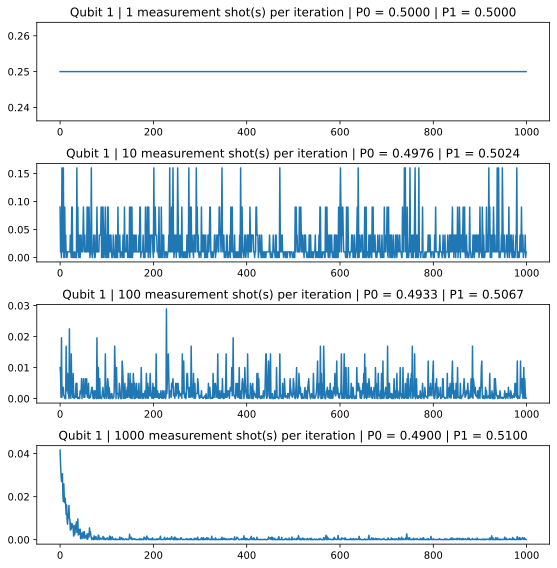

In [9]:
plot_graphs(qubit1_results)

---

## 1.3. Qubit 2

Optimizing $\theta_1$ and $\theta_2$ for qubit 2, which should give us $\lvert1\rangle$ with probability $1$... 

In [11]:
qubit2_results = []

for num_shots in shots:
    
    q2_ckt, q2_thetas, q2_costs = optimize_angles(\
        create_single_qubit_circuit, True, qasm_sim, num_shots, compute_gradient_qubit2, compute_cost_qubit2
    )
    
    qubit2_results.append({'shots': num_shots, 'circuit': q2_ckt, 'angles': q2_thetas, 'costs': q2_costs})


Running gradient descent with shots = 1 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 10 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 100 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 1000 ...
Progress: [####################] 100.0%



Once again, we can see what the resulting probability distributions and cost variations look like for each selection of number of shots...

Iterations vs Cost


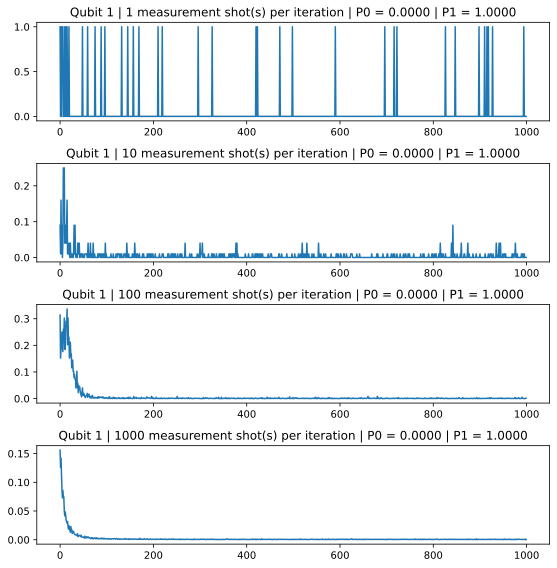

In [12]:
plot_graphs(qubit2_results)

## 1.4. Putting it all together...

In [27]:
final_circuits = []
final_results = []

for idx in range(4):
    
    qubit1_result = qubit1_results[idx]
    qubit2_result = qubit2_results[idx]
    
    final_ckt = create_complete_circuit(qubit1_result['angles'], qubit2_result['angles'])
    
    final_circuits.append(final_ckt)
    final_results.append(execute(final_ckt, backend=qasm_sim, shots=4096, noise_model=None).result())

### 1 measurement shot per iteration

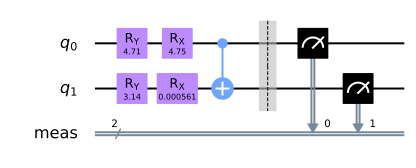

In [28]:
final_circuits[0].draw('mpl')

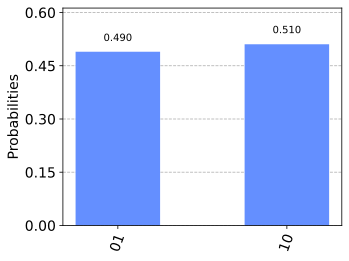

In [29]:
plot_histogram(final_results[0].get_counts(), figsize=(5,4))

---

### 10 measurement shots per iteration

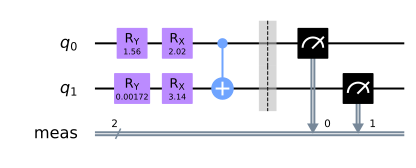

In [16]:
final_circuits[1].draw('mpl')

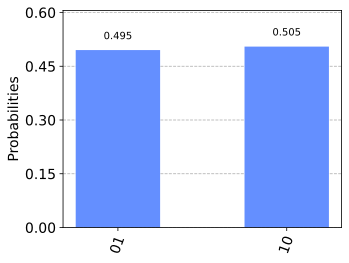

In [30]:
plot_histogram(final_results[1].get_counts(), figsize=(5,4))

---

### 100 measurement shots per iteration

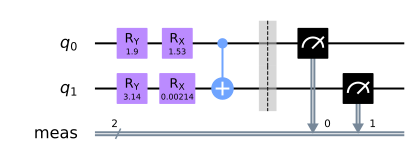

In [31]:
final_circuits[2].draw('mpl')

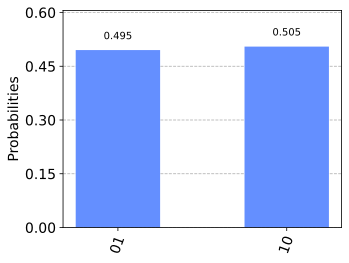

In [32]:
plot_histogram(final_results[2].get_counts(), figsize=(5,4))

---

### 1000 measurement shots per iteration

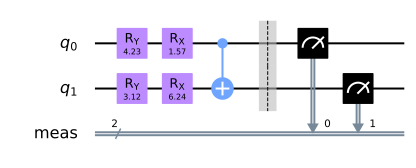

In [20]:
final_circuits[3].draw('mpl')

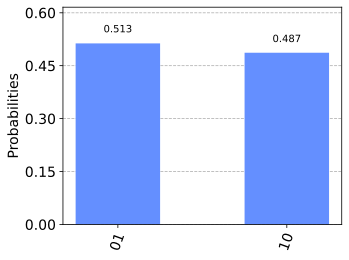

In [33]:
plot_histogram(final_results[3].get_counts(), figsize=(5,4))

### On the QSphere

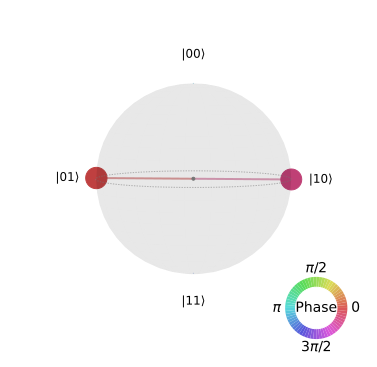

In [21]:
plot_q(
       Statevector.from_label('00').evolve(final_circuits[3].remove_final_measurements(inplace=False)),
       figsize=(6.5, 6.5)
      )

---

# 1.5. Analysis

For the case of 1 measurement shot per iteration, since we're always going to get either 0 or 1, the cost function for qubit 1 remains a constant with time, never varying from 0.25. Similarly, the cost function for qubit 2 oscillates between 0 and 1 depending on the measurement outcome. However, for other values of *shots*, it can be seen (mostly) decreasing over time.  

The noise in the simulator acts as a deterrent, often preventing the optimization algorithm from knowing whether it has "done a good job or not". For example, even if we did take a tiny step in the right direction during the previous iteration, the skewed outcomes from measurement might indicate the opposite, causing the algorithm to adjust to that. Since we are making very small changes to the angles, and because the inherent probabilistic nature of measurement evens out these inaccuracies, we eventually end up at an optimal value.  

_Surprisingly, the number of measurement shots per iteration does **not** seem to have a significant impact on the final outcome, irrespective of whether noise is preset or not_. This is presumably because the probabilities even out over the large number of iterations (5000) that we are running, and because the updates to angles are small enough to remain mostly unaffected.

The plot of the cost function vs time is not a great metric to judge the algorithm by, especially when we simulate with 1 measurement shot per iteration. Even when the cost is "low", the angles have lots of room for improvement.

I noticed that when I ran G.D for a smaller number of iterations (100, 500 etc.), the results obtained with 1 shot were pretty bad, whereas the results obtained with 1000 shots were noticeably better.

---

# 2. Fixed Circuit + Gradient Descent implemented by hand + Noiseless Simulations (no noise and no sampling error)

Out of curiosity, I wanted to see how much better the optimizer would perform in the absence of noise. So I decided to experiment with that as well, using the statevector simulator instead of the QASM simulator. Here, the number of shots does not matter because the simulator does not perform any measurements, instead returning the final statevector. It calculates the measurement probabilities from the probability amplitudes of $\lvert0\rangle$ and $\lvert1\rangle$.

In [22]:
q1_ckt_noiseless, q1_thetas_noiseless, q1_costs_noiseless = \
    optimize_angles(create_single_qubit_circuit, False, statevector_sim, 1, compute_gradient_qubit1, compute_cost_qubit1)

q2_ckt_noiseless, q2_thetas_noiseless, q2_costs_noiseless = \
    optimize_angles(create_single_qubit_circuit, False, statevector_sim, 1, compute_gradient_qubit2, compute_cost_qubit2)


Running gradient descent with shots = 1 ...
Progress: [####################] 100.0%


Running gradient descent with shots = 1 ...
Progress: [####################] 100.0%



Text(0, 0.5, 'Cost')

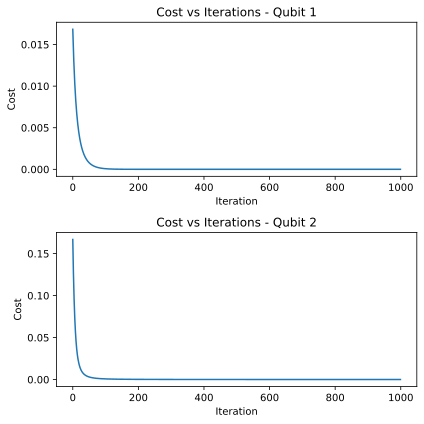

In [23]:
fig2, ax2 = plt.subplots(2)
fig2.set_size_inches(6, 6)
fig2.set_tight_layout(5.0)

ax2[0].plot(range(iterations), q1_costs_noiseless)
ax2[0].set_title("Cost vs Iterations - Qubit 1")
ax2[0].set_xlabel('Iteration')
ax2[0].set_ylabel('Cost')

ax2[1].plot(range(iterations), q2_costs_noiseless)
ax2[1].set_title("Cost vs Iterations - Qubit 2")
ax2[1].set_xlabel('Iteration')
ax2[1].set_ylabel('Cost')

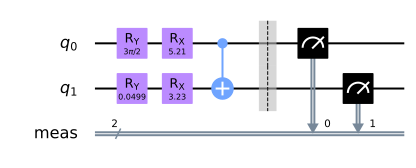

In [24]:
final_ckt_noiseless = create_complete_circuit(q1_thetas_noiseless, q2_thetas_noiseless)

final_ckt_noiseless.draw('mpl')

Let's see what the Statevector looks like on the QSphere:

Output Statevector: [-0.036+0.001j  0.361+0.607j -0.361-0.607j  0.036-0.001j]


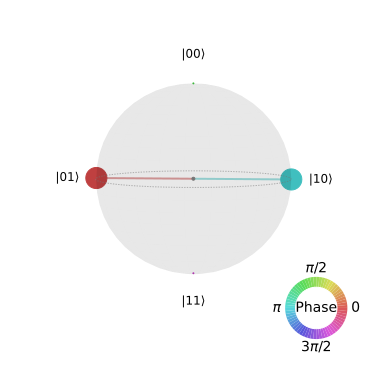

In [25]:
with np.printoptions(precision=3, suppress=True, formatter={'float': '{:0.2f}'.format}, linewidth=100):
    print("Output Statevector: {}" \
          .format(Statevector.from_label('00').evolve(final_ckt_noiseless.remove_final_measurements(inplace=False)).data)
         )
plot_q (
    Statevector.from_label('00').evolve(final_ckt_noiseless.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
    )

And on running it on the QASM simulator...

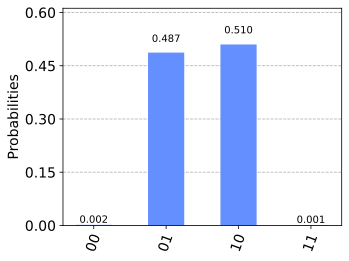

In [26]:
plot_histogram(
    execute(final_ckt_noiseless, backend=qasm_sim, shots=4096).result().get_counts(),
    figsize=(5,4)
)

As expected, it is easier to the see the algorithm converge in the absence of noise. Although this might not have a great impact on the final outcome of the circuit, we are more likely to converge to perfect angles like $\frac{\pi}{2}$ or $\frac{3\pi}{2}$ without the noise...

# 3. Fixed Circuit + Optimization using PySwarm

I also experimented with using PySwarm to optimize the parameters $\theta_1$ and $\theta_2$ using a gradient-free approach like particle swarm optimization.

In [28]:
from pyswarm import pso

Defining the lower and upper bounds for the parameter space...

In [29]:
theta_lower_bound = [0, 0]
theta_upper_bound = [2 * np.pi, 2 * np.pi]

I was forced to redefine the cost functions because this optimization technique searches in the parameter space (here, $\theta_1$ and $\theta_2$) to find an optimum value, and therefore needs the cost functions to be defined in terms of the parameters, preventing us from using $P_0$ and $P_1$.  
This redefinition, however, is trivial because $P_0$ and $P_1$ are also defined in terms of $\theta_1$ and $\theta_2$:
$$
P_0 = \cos^2(\frac{\theta_1}{2}) \cos^2(\frac{\theta_2}{2}) + \sin^2(\frac{\theta_1}{2}) \sin^2(\frac{\theta_2}{2})
\\
P_1 = \cos^2(\frac{\theta_1}{2}) \sin^2(\frac{\theta_2}{2}) + \sin^2(\frac{\theta_1}{2}) \cos^2(\frac{\theta_2}{2})
$$

In [30]:
def pyswarm_compute_cost_qubit1 (thetas):
    t1 = thetas[0]
    t2 = thetas[1]
    p0 = np.cos(t1/2)**2 * np.cos(t2/2)**2 + np.sin(t1/2)**2 * np.sin(t2/2)**2
    
    return (p0 - 0.5) ** 2

def pyswarm_compute_cost_qubit2 (thetas):
    t1 = thetas[0]
    t2 = thetas[1]
    p0 = np.cos(t1/2)**2 * np.cos(t2/2)**2 + np.sin(t1/2)**2 * np.sin(t2/2)**2
    
    return (p0) ** 2

We can now call `pso` to optimize over $\theta_i$. In the spirit of accuracy, and because this algorithm has a nearly negligible runtime, I set `minfunc` and `minstep` to $10^{-12}$ and `swarmsize` to 1000. This means that the algorithm uses 1000 particles and will stop only when either the minimum stepsize or the of the swarm’s best position is $10^{-12}$ or the change in the cost function is $10^{-12}$.

In [31]:
swarm_thetas_1, _ = pso(\
    pyswarm_compute_cost_qubit1, theta_lower_bound, theta_upper_bound, minstep=1e-12, minfunc = 1e-12, swarmsize=1000\
)
swarm_thetas_2, _ = pso(\
    pyswarm_compute_cost_qubit2, theta_lower_bound, theta_upper_bound, minstep=1e-12, minfunc=1e-12, swarmsize=1000\
)

Stopping search: Swarm best objective change less than 1e-12
Stopping search: Swarm best objective change less than 1e-12


In [32]:
print("Qubit 1 Angles = {} \nQubit 2 Angles = {}".format(swarm_thetas_1, swarm_thetas_2))

Qubit 1 Angles = [1.57918532 4.71198016] 
Qubit 2 Angles = [6.28318531 3.1414693 ]


We can now create a circuit with these parameters and simulate it using Qiskit once again...

Circuit optimized using PySwarm...


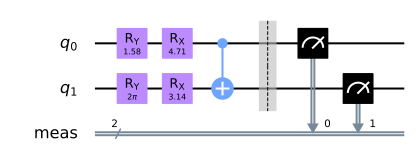

In [33]:
pyswarm_circuit = create_complete_circuit(swarm_thetas_1, swarm_thetas_2)
print("Circuit optimized using PySwarm...")
pyswarm_circuit.draw('mpl')

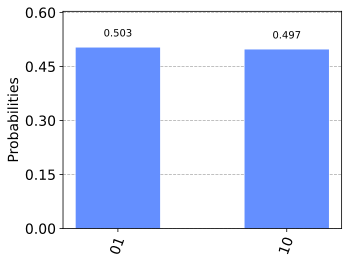

In [34]:
plot_histogram(
    execute(pyswarm_circuit, qasm_sim, shots=4096).result().get_counts(),
    figsize=(5,4)
)

And on the QSphere...

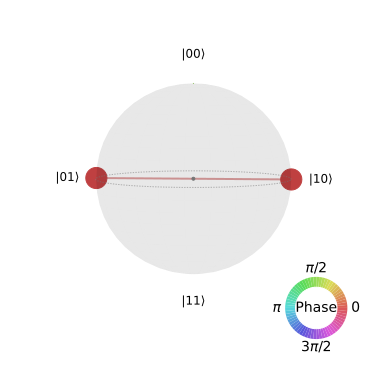

In [35]:
plot_q(
    Statevector.from_label('00').evolve(pyswarm_circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

## 4. Bonus - getting the circuit to produce $\frac{1}{\sqrt2}\lvert01\rangle + \frac{1}{\sqrt2}\lvert10\rangle$

So far, our circuits have just been asked to produce states that are equally likely to collapse to $\lvert01\rangle$ and $\lvert10\rangle$. There are infinitely many states conforming to this specification, and so in the absence of a stricter cost function, and because we are optimizing using the measurement probabilities, the circuits are free to generate any of these states.

If we want to produce the Bell State $\frac{1}{\sqrt2}\lvert01\rangle + \frac{1}{\sqrt2}\lvert10\rangle$, our cost function will have to change a little bit for qubit 1. We now want qubit 1 to end up exactly in the $\lvert+\rangle = \frac{1}{\sqrt2}\lvert0\rangle + \frac{1}{\sqrt2}\lvert1\rangle$ state. In other words, our $R_y + R_x$ combination should behave like a Hadamard gate.

Going back to our initial calculations, we know that the final state, parametrized by $\theta_1$ and $\theta_2$ is:

$$
\begin{bmatrix} 
    cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) - isin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) \\
    -icos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) + sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})
\end{bmatrix}
$$

However, getting our qubit to end up in $\lvert+\rangle$ with the fixed circuit structure we have is **equivalent to getting it into the state $\lvert0\rangle$ using the same circuit but with an additional Hadamard gate before the measurement (corresponding to a measurement in the X basis)**.  
  
So now we've added an additional Hadamard Gate at the end ofour circuit, which means our final output is of the form:

$$
\frac{1}{\sqrt2}
\begin{bmatrix} 
    \left[cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) + sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})\right] - i\left[sin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) + cos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2})\right]\\
    \left[cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) - sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})\right] + i\left[cos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) - sin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2})\right]
\end{bmatrix}
$$  

We can simplify this by taking out the common terms to get:
$$
\frac{1}{\sqrt2}
\begin{bmatrix} 
    (cos\frac{\theta_1}{2} + sin\frac{\theta_1}{2})\\
    (cos\frac{\theta_1}{2} - sin\frac{\theta_1}{2})e^{i\theta_2}
\end{bmatrix}
$$

We want to both minimize the probability of getting output $\lvert1\rangle$, and eliminate the relative phase of $\theta_2$. Eliminating the relative phase can be achieved by bringing $sin\theta_2$ as close to $0$ as possible.  

I will skip the rest of the calculation, since the simplification is similar to that of the original question above...

$$
\begin{aligned}
J_1 & = (cos\frac{\theta_1}{2} - sin\frac{\theta_1}{2})^2 + sin^2\theta_2\\
& = (1-sin\theta_1)^2 + sin^2\theta_2\\
& = 4P_1^2 + sin^2\theta_2\\
\\
P_0 & = \frac{1+sin\theta_1}{2}\\
P_1 & = \frac{1-sin\theta_1}{2}\\
\\
\frac{\partial J}{\partial \theta_1} & = -4P_1cos\theta_1\\
\frac{\partial J}{\partial \theta_2} & = sin(2\theta_2)
\end{aligned}
$$
  
  
We don't need to worry about qubit 2 because any global phase generated during its optimization will have no impact on the final state. So, we can reuse the original cost and gradient functions.

In [36]:
def bonus_create_circuit_q1(thetas, measure):
    ckt = create_single_qubit_circuit(thetas, False)
    ckt.h(0)
    if measure:
        ckt.measure_all()
        
    return ckt

def bonus_compute_cost_qubit1(p0, p1):
    # there is no way of getting the relative phase from p0 and p1, and this value does not affect the algorithm in any way
    # so, in the interest of keeping the code clean, I have left it at 4p1^2 
    return 4 * p1 ** 2 

def bonus_compute_gradient_qubit1(alpha, thetas, p0, p1):
    return [-4 * p1 * np.cos(thetas[0]), np.sin(2*thetas[1])]

In [37]:
print("Optimizing for qubit 1...")
bonus_q1_ckt, bonus_q1_thetas, bonus_q1_costs = optimize_angles(\
        bonus_create_circuit_q1, True, qasm_sim, 1000, bonus_compute_gradient_qubit1, bonus_compute_cost_qubit1
)

print("\nOptimizing for qubit 2...")
bonus_q2_ckt, bonus_q2_thetas, bonus_q2_costs = optimize_angles(\
        create_single_qubit_circuit, True, qasm_sim, 1000, compute_gradient_qubit2, compute_cost_qubit2
)

Optimizing for qubit 1...

Running gradient descent with shots = 1000 ...
Progress: [####################] 100.0%


Optimizing for qubit 2...

Running gradient descent with shots = 1000 ...
Progress: [####################] 100.0%



Now that we have our optimized angles, we can create our circuit as usual...

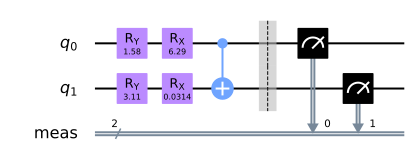

In [38]:
bonus_final_circuit = create_complete_circuit(bonus_q1_thetas, bonus_q2_thetas)
bonus_final_circuit.draw('mpl')

Verifying that the measurement probabilities check out...

In [39]:
# without noise
bonus_final_state = Statevector.from_label('00').evolve(bonus_final_circuit.remove_final_measurements(False))
bonus_final_state.probabilities_dict()

{'00': 0.0002468411134826502,
 '01': 0.5045563735641213,
 '10': 0.49494515085977137,
 '11': 0.0002516344626247727}

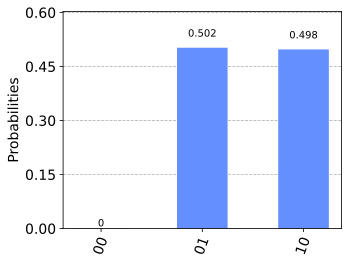

In [40]:
# with noise
plot_histogram(
    execute(bonus_final_circuit, backend=qasm_sim, shots=4096, noise_model=noise_model).result().get_counts(),
    figsize=(5,4)
)

And checking the QSphere for any relative phase...

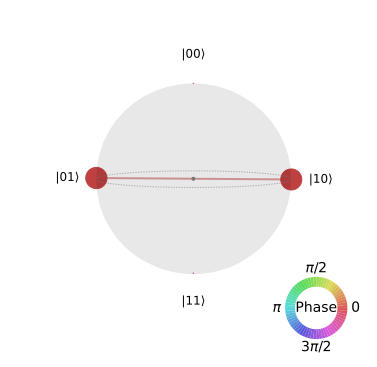

In [41]:
plot_q(bonus_final_state, figsize=(6.5, 6.5))

### We can see that there's no relative phase between the $\lvert01\rangle$ and $\lvert10\rangle$ states, meaning that (up to a global phase), our generated state is equivalent to the Bell State $\frac{1}{\sqrt2}\lvert01\rangle + \frac{1}{\sqrt2}\lvert10\rangle$

---

## 4. Bonus - getting the circuit to produce $\frac{1}{\sqrt2}\lvert01\rangle + \frac{1}{\sqrt2}\lvert10\rangle$ using PySwarm

For the sake of completeness, I also optimized for the bonus question using PySwarm...  
Note that $4P_0^2$ is equivalent to $(1-sin\theta_1)^2$ from the calculations shown previously... 

In [42]:
bonus_theta_lower_bound = [0, 0]
bonus_theta_upper_bound = [2 * np.pi, 2 * np.pi]

def bonus_pyswarm_compute_cost_qubit1 (thetas):
    return (1 - np.sin(thetas[0])) ** 2 + np.sin(thetas[1]) ** 2

def bonus_pyswarm_compute_cost_qubit2 (thetas):
    return pyswarm_compute_cost_qubit2(thetas)

In [43]:
bonus_swarm_thetas_1, _ = pso(\
    bonus_pyswarm_compute_cost_qubit1, bonus_theta_lower_bound, bonus_theta_upper_bound, minstep=1e-12, swarmsize=1000\
)
bonus_swarm_thetas_2, _ = pso(\
    bonus_pyswarm_compute_cost_qubit2, bonus_theta_lower_bound, bonus_theta_upper_bound, minstep=1e-12, swarmsize=1000\
)

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


Bonus | Circuit optimized using PySwarm...


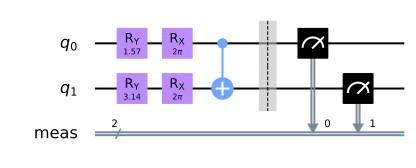

In [44]:
bonus_pyswarm_circuit = create_complete_circuit(bonus_swarm_thetas_1, bonus_swarm_thetas_2)
print("Bonus | Circuit optimized using PySwarm...")
bonus_pyswarm_circuit.draw('mpl')

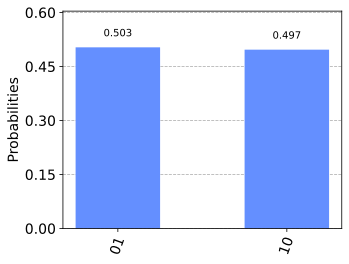

In [45]:
plot_histogram(
    execute(bonus_pyswarm_circuit, qasm_sim, shots=4096).result().get_counts(),
    figsize=(5,4)
)

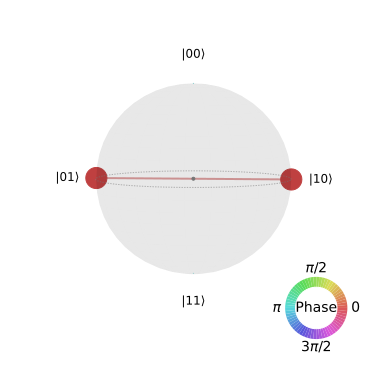

In [46]:
plot_q(
    Statevector.from_label('00').evolve(bonus_pyswarm_circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

Clearly, PySwarm does a great job of optimizing the angles - it found the optimal values to be 1.57 and 3.14! There's also no relative phase betwween the 2 components of our generated State, proving that it is equivalent to the Bell State up to a global phase! 

---

## Conclusion

Thank you for reading! And thank you for the interesting questions! I had a great time implementing them and learnt a lot! Have a good day!